In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, average_precision_score, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
import seaborn as sns; sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set2')
%matplotlib inline


# Define Helper Functions

In [2]:
def probability_to_label(probabilities, threshold=0.5):
    probabilities = list(probabilities)
    th = threshold
    predictions = [1 if i > th else 0 for i in probabilities]
    return predictions

In [3]:
def plot_cm(y_true, y_pred,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    sns.set_style('white')
    
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normarlize 
    
    from sklearn.utils.multiclass import unique_labels
    classes = unique_labels(y_true, y_pred)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    pass

In [4]:
def Imp_of_fea(name,weight):
    import operator
    import collections
    dic = dict(zip(name,weight))
    key_drop = [k for k in dic.keys() if  k == 'icustay_age_group']
    for k in key_drop:
        del dic[k]
    dic = sorted(dic.items(), key=operator.itemgetter(1))
    sorted_dict = collections.OrderedDict(dic)
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(5,20))
    plt.barh(list(sorted_dict.keys()),list(sorted_dict.values()))
    plt.title('Importance of features in 30 day mortality')

In [5]:
def plot_ROC(fpr, tpr, auc, title = 'ROC curve'):
    sns.set_style('whitegrid')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=' (AUC = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    pass

In [6]:
def plot_PRC(precision, recall, ap, title= 'Precision-Recall Curve '):
    sns.set_style('whitegrid')

    plt.figure
#     plot(result5_1[0], result5_1[1],linestyle = "-", color = 'C0')#,label = 'AUC = %0.2f' % result5_1[3])
    plt.plot(recall, precision, lw=2, label='AP = %0.4f' % ap )
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")
#     plt.show()
    return 

In [7]:
def get_weights(y):
    zeros = y[y==0].shape[0]
    ones = y[y==1].shape[0]
    weight = np.array([zeros, ones])*1.0/y.shape[0]
    y = np.where(y==0,weight[1],y)
    y = np.where(y==1,weight[0],y)
    return y

## Load Data

In [8]:
%run LoadData30D.ipynb

Loaded 30 Days Train Sample:
X_train shape: (38857, 106)
38857 train samples
Loaded 30 Days Test Sample:
X_test shape: (38857, 106)
19139 test samples


In [9]:
X_train.head()

,first_careunit,last_careunit,age,gender,marital_status,insurance,urea_n_min,urea_n_max,urea_n_mean,platelets_min,...,meanbp_mean_mv,spo2_min_mv,spo2_max_mv,spo2_mean_mv,vent_mv,rrt_mv,urineoutput_mv,oasis_mv,lods_mv,sirs_mv
0,0.358226,-0.375558,-0.091698,-1.125040,0.002484,0.721077,0.336293,0.533833,0.568295,-0.307287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.058760,1.040694,-0.138448,-1.125040,-0.795334,0.721077,1.458096,0.982380,1.364434,-0.617702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.358226,-0.375558,4.139580,-1.125040,-0.795334,0.721077,-0.411576,-0.523458,-0.401365,-1.206421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.058760,1.040694,0.115679,-1.125040,-0.795334,0.721077,0.261506,-0.395301,-0.145096,2.058292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.358226,-0.375558,-0.268887,0.888858,0.800302,-0.508846,0.111932,-0.299184,-0.088050,-1.067269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
y_train.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: thirty_days, dtype: float64

# Naive Bayes

### Apply SearchGrid Cross Validation

In [11]:
param_grid = { 
    'var_smoothing' : list(np.logspace(1e-1,1e-15,100))
}
model = GridSearchCV(
    estimator = GaussianNB(),
    param_grid = param_grid,
    n_jobs = -1,
    verbose = 3,
    scoring = 'accuracy',
    cv = 5
).fit(X_train,y_train,get_weights(y_train.values))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


In [12]:
best_model = model.best_estimator_
ypred = best_model.predict_proba(X_test)
np.savetxt("plot metric/y_score_30_GNB.csv", ypred[:,1], delimiter=",")

### Accuracy Score

In [13]:
best_model.score(X_test,y_test)

0.8416322691885678

### Importance of Features

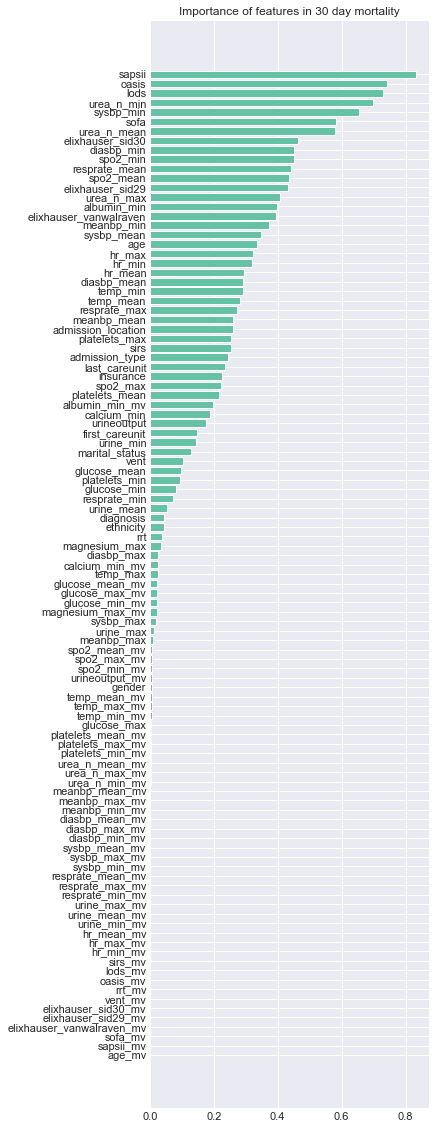

In [14]:
name = X_train.columns
weight = list(abs(best_model.theta_.T[:,1]))
Imp_of_fea(name,weight)

### Confusion Matrix

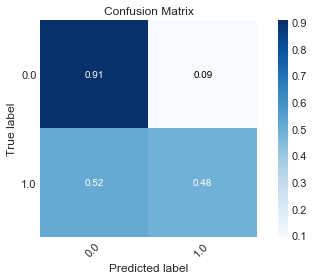

In [15]:
ypred_label =  probability_to_label(ypred[:,1], threshold=0.5)
plot_cm(y_test, ypred_label)

### ROC Curve and AUC

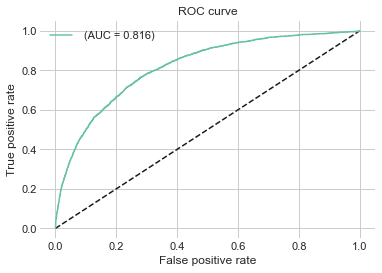

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, ypred[:,1])
auc = auc(fpr,tpr)
plot_ROC(fpr, tpr, auc, title = 'ROC curve')

### PRC Curve

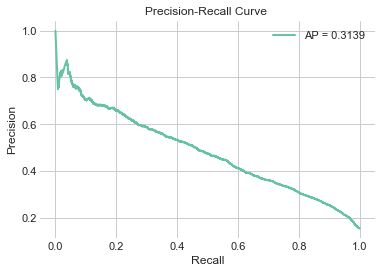

In [17]:
avg_prec = average_precision_score(y_test, ypred_label)
prec, recall,_ = precision_recall_curve(y_test,ypred[:,1])
plot_PRC(prec, recall, avg_prec, title= 'Precision-Recall Curve ')

### F1 Score

In [18]:
f1_score(y_test,ypred_label)

0.48443612859329815